In [6]:
# Import required libraries for this code block
import os
import sys
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import glob
from matplotlib.image import imread
import re

# Add gradient_utils path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '092325_cortical_gradients')))
from gradient_utils import *

# ==== PATHS/SETTINGS ====
BASE_PATH = '/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/'
HCP_STRUCTURAL_COVARIANCE_PATH = os.path.join(os.getcwd(), '..', '092325_cortical_gradients', 'HCP')
EXVIVO_STRUCTURAL_COVARIANCE_PATH = os.path.join(os.getcwd(), '..', '092325_cortical_gradients', 'EXVIVO_FINAL')
SURF_WHITE_RH_PATH = f'{BASE_PATH}/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'
SURF_WHITE_LH_PATH = f'{BASE_PATH}/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
TARGET_DISTANCE = 'long'

# ==== Load Tract Data and Compute Group Average ====
TRACT_DATA_PATH = os.path.join(BASE_PATH, 'data', 'tract_data', 'from_jkai', 'corticocortical_avg_length')
tract_files = os.listdir(TRACT_DATA_PATH)
tract_data_all = [
    np.load(os.path.join(TRACT_DATA_PATH, file), allow_pickle=True) 
    for file in tract_files
]
tract_data_mean = np.mean(np.array(tract_data_all), axis=0)
print(tract_data_mean.shape)
TRACT_DISTANCE_RANGE = np.arange(10, 120, 10)

# ==== Load Atlas & Split Hemispheres ====
atlas_path = f'{BASE_PATH}/parcellation/Schaefer/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
half_len = len(atlas) // 2

atlas_data_lh = atlas[:half_len]
atlas_data_rh = atlas[half_len:]
atlas_data_rh = atlas_data_rh - np.min(atlas_data_rh[atlas_data_rh != 0]) + 1
atlas_data_rh[atlas_data_rh <= 0] = 0

metrics = [
    'total_hcp', 'total', 'supra', 'infra', 'ratio_supra', 'relative'
]

# ==== Gradient Analysis/Alignment Parameters ====
G_sparsity = 0  # set to zero for no sparsity
G_dimension_reduction = 'pca'
G_kernel = 'normalized_angle'
N_components = 10
N_components_plot = 3

align_to_total = True
do_rotation = True   # For "reflection and reorder", rotation needs to be True
do_reflection = True

mask_index_lh = np.nan
mask_index_rh = np.nan

# ==== Data Structures for Results ====
lh_data_all = {m: {} for m in metrics}
lh_aligned_all = {m: {} for m in metrics}
R_lh_all = {m: {} for m in metrics}
R_lh_aligned_all = {m: {} for m in metrics}

# ==== Main Loop: Compute and Align Gradients ====
for i, tract_distance in enumerate(TRACT_DISTANCE_RANGE):
    for metric in metrics:

        # --- Load Data ---
        if metric == 'total_hcp':
            data2plot_lh = np.load(
                os.path.join(HCP_STRUCTURAL_COVARIANCE_PATH, f"{metric}_corr_lh.npy"), allow_pickle=True
            ).item()[0]
        else:
            data2plot_lh = np.load(
                os.path.join(EXVIVO_STRUCTURAL_COVARIANCE_PATH, f"{metric}_corr_lh.npy"), allow_pickle=True
            ).item()[0]

        # --- Mask by Tract Distance ---
        if TARGET_DISTANCE == 'long':
            mask = tract_data_mean > tract_distance
        elif TARGET_DISTANCE == 'short':
            mask = tract_data_mean < tract_distance
        else:
            raise ValueError(f"Invalid TARGET_DISTANCE: {TARGET_DISTANCE}")

        data_masked_lh = np.where(mask, data2plot_lh, np.nan)
        mask_lh = atlas_data_lh != 0

        # --- Compute Gradients using BrainSpace ---
        gm_all_lh, grad_all_lh = calculate_gradients_from_brainspace(
            data_masked_lh, mask_index_lh, atlas_data_lh, mask_lh, N_components,
            g_dimension_reduction=G_dimension_reduction, g_sparsity=G_sparsity, g_kernel=G_kernel
        )

        # --- Align Gradients ---
        grad_all_aligned_hemi_lh, R_lh = align_gradients(
            np.array(grad_all_lh).T,
            np.array(grad_all_lh).T,
            reflection=do_reflection,
            rotation=do_rotation
        )

        # --- Declare Variables for Final Aligned Gradients/Matrices ---
        grad_all_aligned_lh = []
        R_lh_hcp = []

        # --- Align to "Total" if requested ---
        if align_to_total:
            # For metrics other than total/total_hcp, align to total
            if metric != 'total' and metric != 'total_hcp':
                _, R_lh = align_gradients(
                    grad_all_aligned_hemi_lh,
                    lh_data_all['total'][0],
                    reflection=do_reflection,
                    rotation=do_rotation
                )
                # Decompose transform matrix for permutation and sign flip
                perm_idx_lh, signs_lh = decompose_to_permutation_and_signs(R_lh)
                grad_all_aligned_lh = grad_all_aligned_hemi_lh[:, perm_idx_lh] * signs_lh
            else:
                grad_all_aligned_lh, R_lh = align_gradients(
                    grad_all_aligned_hemi_lh,
                    grad_all_aligned_hemi_lh,
                    reflection=do_reflection,
                    rotation=do_rotation
                )

        # --- Store Results ---
        lh_aligned_all[metric][i] = grad_all_aligned_lh
        R_lh_aligned_all[metric][i] = R_lh_hcp

        lh_data_all[metric][i] = grad_all_aligned_hemi_lh
        R_lh_all[metric][i] = R_lh


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(200, 200)


In [7]:
#save gradient outputs
savepath = f'./gradients_output/{TARGET_DISTANCE}'

if not os.path.exists(savepath):
    os.makedirs(savepath)

import pickle

# Save lh_data_all and TRACT_DISTANCE_RANGE to a pickle file
with open(os.path.join(savepath, 'lh_data_all_and_tract_distance_aligned_range.pkl'), 'wb') as f:
    pickle.dump({'lh_aligned_all': lh_aligned_all, 'TRACT_DISTANCE_RANGE': TRACT_DISTANCE_RANGE}, f)

with open(os.path.join(savepath, 'lh_data_all_and_tract_distance_range.pkl'), 'wb') as f:
    pickle.dump({'lh_data_all': lh_data_all, 'TRACT_DISTANCE_RANGE': TRACT_DISTANCE_RANGE}, f)
    

Metrics: ['HCP: total', 'Ex: total', 'Ex: supra', 'Ex: infra', 'Ex: supra/total', 'Ex: supra/infra']
Array shape: (32492, 10) (n_vertices x n_components)
Component 0 matrix shape: (32492, 6)
Component 1 matrix shape: (32492, 6)
Metrics: ['HCP: total', 'Ex: total', 'Ex: supra', 'Ex: infra', 'Ex: supra/total', 'Ex: supra/infra']
Array shape: (32492, 10) (n_vertices x n_components)
Component 0 matrix shape: (32492, 6)
Component 1 matrix shape: (32492, 6)
Metrics: ['HCP: total', 'Ex: total', 'Ex: supra', 'Ex: infra', 'Ex: supra/total', 'Ex: supra/infra']
Array shape: (32492, 10) (n_vertices x n_components)
Component 0 matrix shape: (32492, 6)
Component 1 matrix shape: (32492, 6)
Metrics: ['HCP: total', 'Ex: total', 'Ex: supra', 'Ex: infra', 'Ex: supra/total', 'Ex: supra/infra']
Array shape: (32492, 10) (n_vertices x n_components)
Component 0 matrix shape: (32492, 6)
Component 1 matrix shape: (32492, 6)
Metrics: ['HCP: total', 'Ex: total', 'Ex: supra', 'Ex: infra', 'Ex: supra/total', 'Ex: s

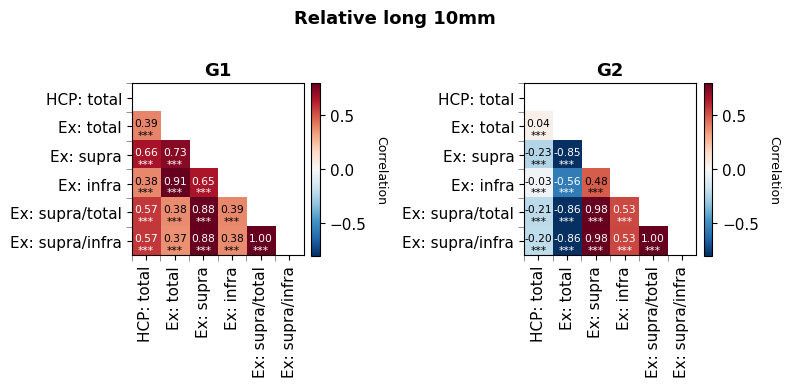

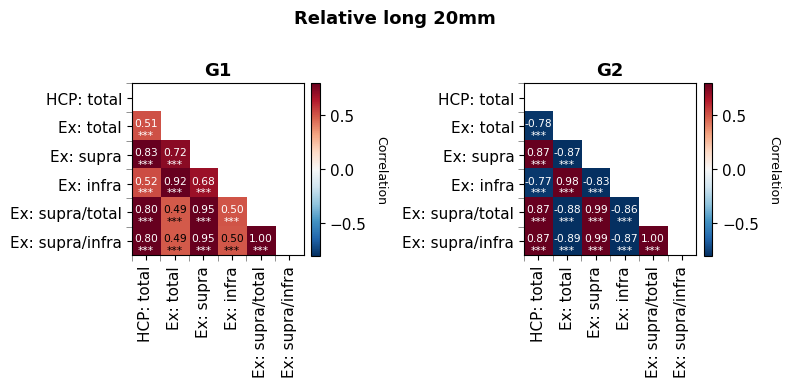

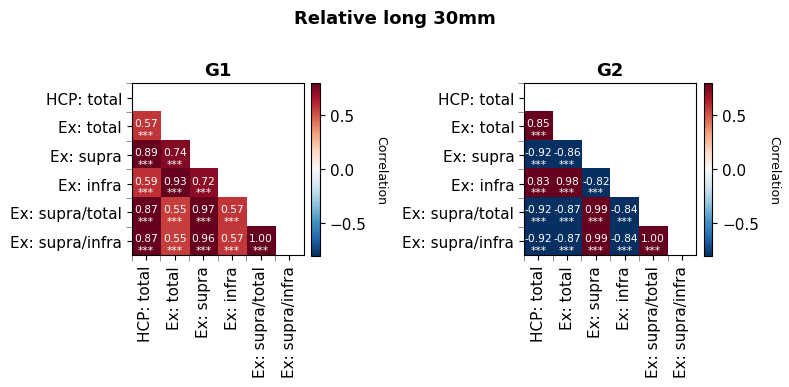

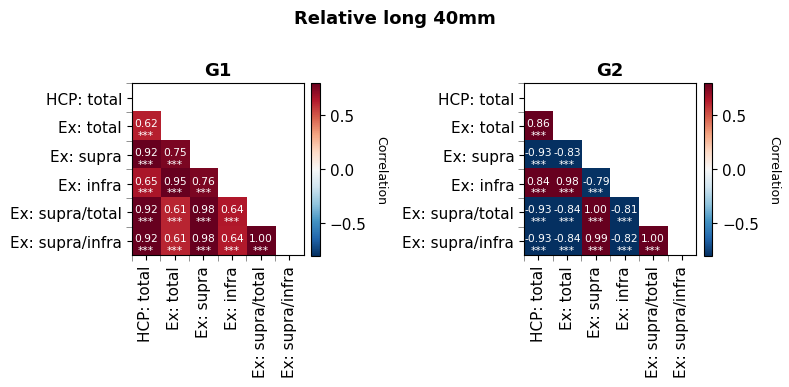

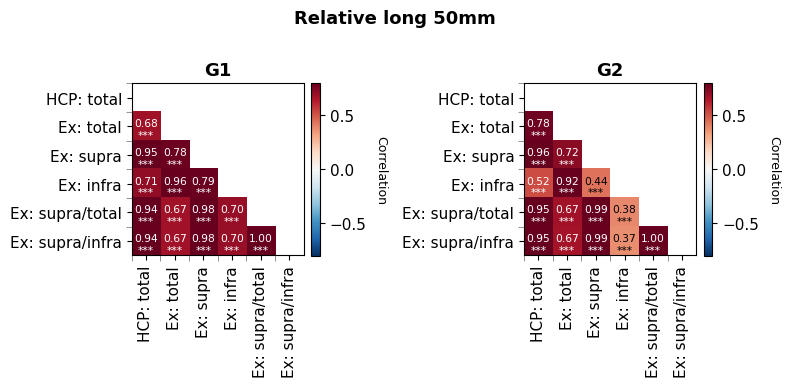

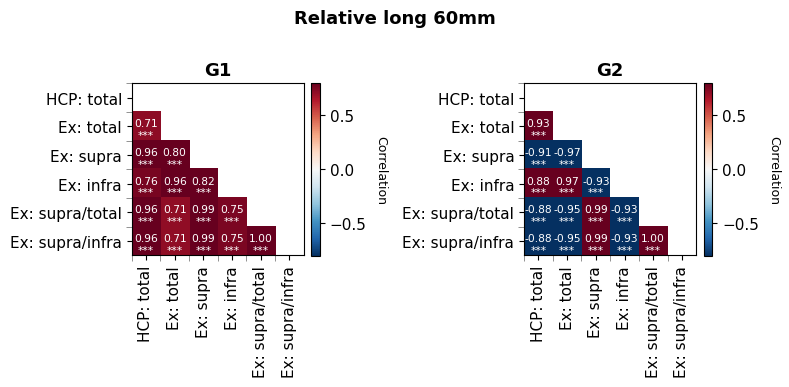

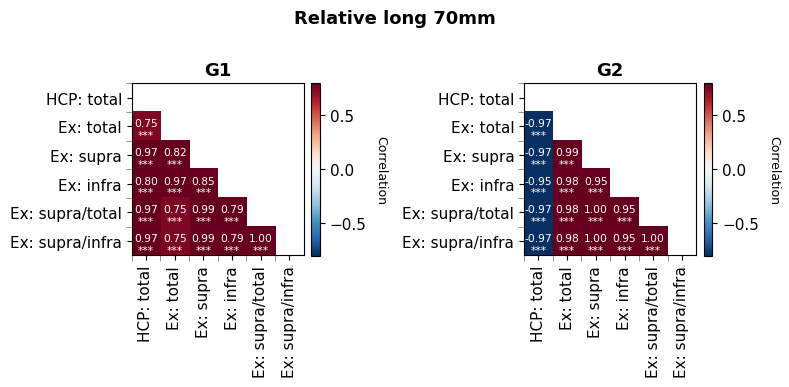

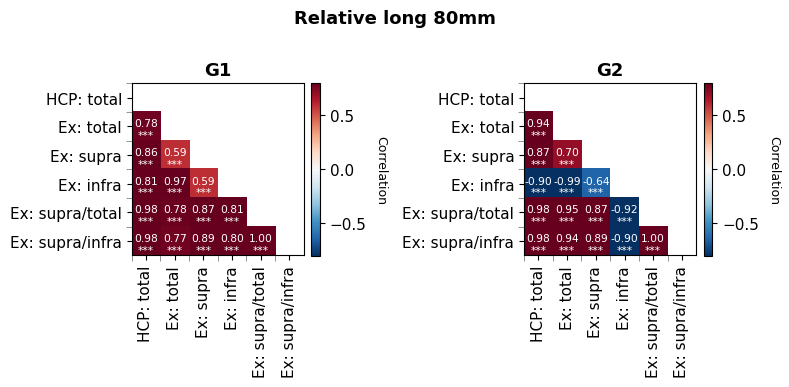

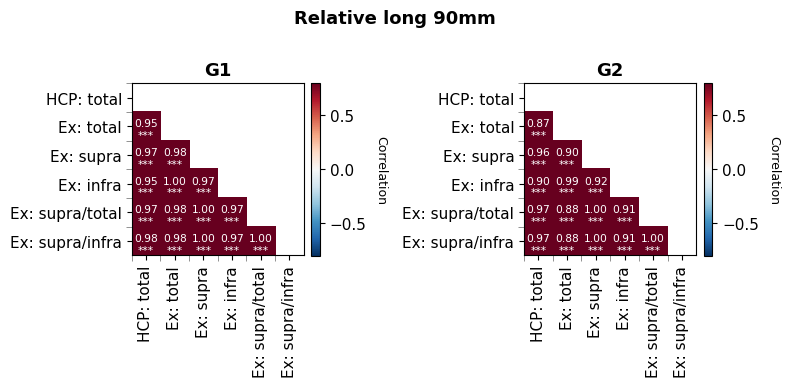

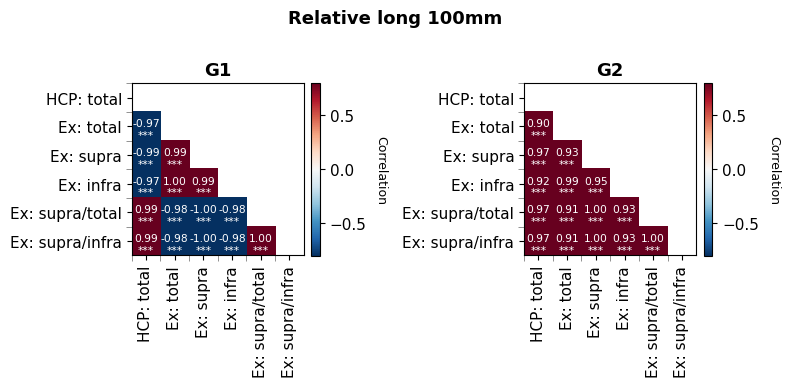

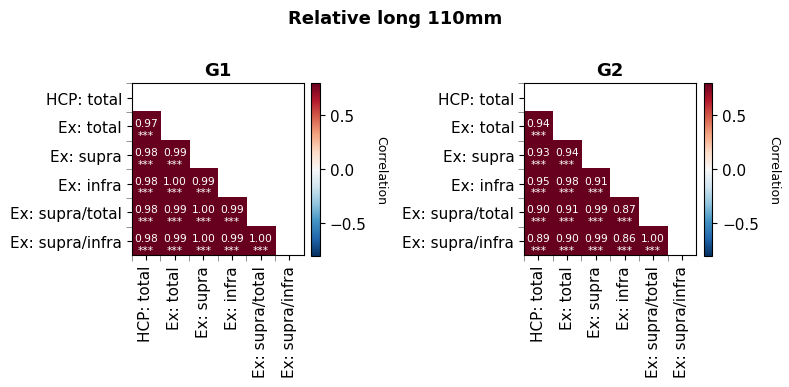

In [8]:
# Example usage
# Add gradient_utils path
DO_SPIN_TEST = False


data2plot = lh_data_all.copy()

for tract_distance in TRACT_DISTANCE_RANGE:
    sparsity_index = [i for i, x in enumerate(TRACT_DISTANCE_RANGE) if x == tract_distance][0]
    # Plot with significance markers
    _,_,_,_ = plot_component_correlation(
        data2plot,
        n_components=2,
        sparsity_index=sparsity_index,
        colormap='RdBu_r',
        fontsize=11,
        show_values=True,
        show_significance=True,
        alpha=0.05,
        do_spin_test=DO_SPIN_TEST,
        hemi='lh',
        title=f'{metric.capitalize()} {TARGET_DISTANCE} {tract_distance}mm'
    )



In [9]:
# --- MAIN EXECUTION --
import os, sys, importlib.util
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../011426_distance_vs_functionalconn')))
from util_fcgaplot import *

util_import_path = os.path.join(os.getcwd(), "../092325_cortical_gradients/gradient_utils.py")


for LAYER_TYPE in metrics:
    SAVEPATH = f'./figures/{LAYER_TYPE}/{TARGET_DISTANCE}/'

    SURF_WHITE_LH_PATH = f'{BASE_PATH}/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'

    for i, tract_distance in enumerate(TRACT_DISTANCE_RANGE):
        data_name = f'{LAYER_TYPE}_{TARGET_DISTANCE}_{tract_distance}mm'
        if not os.path.exists(SAVEPATH):
            os.makedirs(SAVEPATH)
        reconstructed_data = lh_aligned_all[LAYER_TYPE][i]
        gradient_utils = import_gradient_utils(util_import_path)
        fig = plot_gradients_on_surface(
            gradient_utils, {0: reconstructed_data}, SURF_WHITE_LH_PATH, N_components_plot=3, cmap='RdBu_r'
        )
        fig.savefig(os.path.join(SAVEPATH, f'{data_name}_gradients_schaefer400.png'))
        plt.close(fig)

    # Combine only the 32k gradient result figures in a large figure, ordered by mm in filename

    # Get only PNG files in SAVEPATH directory that include '32k' in filename
    TARGET_NAME = 'schaefer'
    fig_paths = sorted(
        [p for p in glob.glob(os.path.join(SAVEPATH, '*png'))
        if TARGET_NAME in os.path.basename(p) and 'mm' in os.path.basename(p) and LAYER_TYPE in os.path.basename(p)],
        key=lambda x: extract_mm_value(os.path.basename(x))
    )

    n_figs = len(fig_paths)
    if n_figs == 0:
        print(f"No {TARGET_NAME} figures found.")
    else:
        n_cols = 4 if n_figs >= 4 else n_figs
        n_rows = int(np.ceil(n_figs / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

        # Normalize axs to 2D array
        axs = np.array(axs).reshape(n_rows, n_cols)

        for idx, fig_path in enumerate(fig_paths):
            row, col = divmod(idx, n_cols)
            ax = axs[row, col]
            ax.imshow(imread(fig_path))
            ax.set_title(os.path.basename(fig_path), fontsize=10)
            ax.axis('off')

        # Hide unused subplots
        for empty_idx in range(n_figs, n_rows * n_cols):
            row, col = divmod(empty_idx, n_cols)
            axs[row, col].axis('off')

        plt.tight_layout()
        fig.savefig(os.path.join(SAVEPATH, f'{TARGET_NAME}_{TARGET_DISTANCE}_all_figures.png'))
        plt.close(fig)

Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py


Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe

Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe

Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe

Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe

Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe

Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe

Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe

Context leak detected, msgtracer returned -1


Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
Succe